# Lets play pool

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython import display

In [2]:
im = cv2.imread('./test_images/pool.png')[:,:,[2,1,0]]

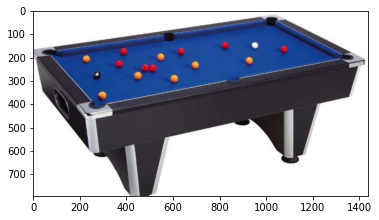

In [3]:
plt.imshow(im)
plt.show()

Let's find the boundaries of the table by segmenting out the blue region

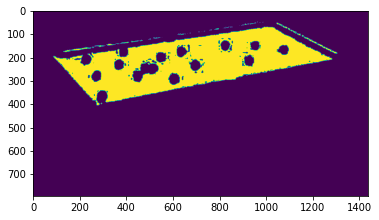

In [4]:
felt = (im[:,:,2]<165)&(im[:,:,2]>135)&(im[:,:,0]<35)
plt.imshow(felt)
plt.show()

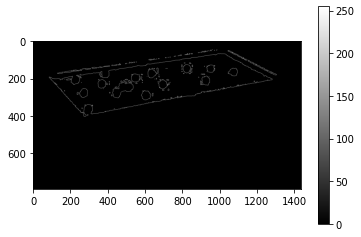

In [5]:
edges = cv2.Canny(felt.astype(np.uint8)*255,100,200)

plt.imshow(edges,cmap = 'gray')
plt.colorbar()
plt.show()

Last week we saw that ransac was a really good way of fitting homographies, by discarding outliers, but this idea can be used to fit any model. Let's use it to fit straight lines to find the edges of the pool table.

We'll extend ransac to return all lines with sufficient evidence (an edge response), and with a gradient that differs from others.

Recall that the equation of a line is $y = mx + c$, we can draw two edge points at random, fit a line through these, and then check consensus, repeating until we find all the key lines. We'll use lines and conics to achieve this efficiently. Let's visualise this.

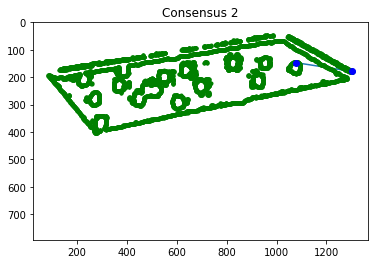

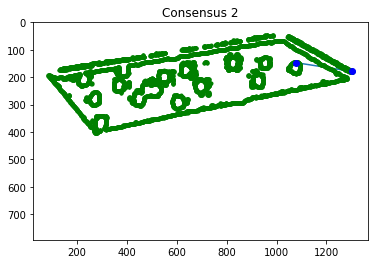

In [6]:
# get all edgels
points_x,points_y = np.where(edges>0)
# convert to homogenous coordinates
points_homog = np.vstack([points_x,points_y,np.ones(len(points_x))]).T

for j in range(20):
    
    # Pick two points at random
    bins = np.random.choice(len(points_x),2,replace=False)

    # find the line intersecting these using the cross (wedge) product
    line = np.cross(points_homog[bins[0],:],points_homog[bins[1],:])

    # Check how many other points lie within 5 pixels of this using the dot product
    consensus = (np.abs(np.sum(line*points_homog,axis=-1)) < 5)
   
    plt.clf()
    plt.plot(points_homog[bins,1],points_homog[bins,0])
    bins_c = consensus
   
    plt.plot(points_homog[~bins_c,1],points_homog[~bins_c,0],'g.')
    plt.plot(points_homog[bins_c,1],points_homog[bins_c,0],'bo')
    plt.title('Consensus %d'%np.sum(consensus))
    plt.ylim(edges.shape[0],0)
            
    display.clear_output(wait=True)
    display.display(plt.gcf())

Cool, let's turn this into a function to find the boundaries

In [7]:
def ransac_line(image,N=1000,max_error=5, existing_line_threshold=5):
    
    good_lines = []
    consensus_list = []
    
    points_x,points_y = np.where(edges>0)
    points_homog = np.vstack([points_x,points_y,np.ones(len(points_x))]).T
    
    for j in range(N):

        bins = np.random.choice(len(points_x),2,replace=False)

        line = np.cross(points_homog[bins[0],:],points_homog[bins[1],:])
        
        line = line/np.sqrt(line[0]**2 + line[1]**2)
        
        line = line.reshape(1,3)

        consensus = np.sum((np.abs(np.sum(line*points_homog,axis=-1)) <= max_error))
        
        if len(good_lines) > 0:


            # Check if line already found by comparing intercepts
            c_good = -np.vstack(good_lines)[:,2]/(np.vstack(good_lines)[:,0]+1e-19)
            c_line = -line[0,2]/(line[0,0]+1e-19)  

            d = np.abs(c_good-c_line)
            best_d = np.argmin(d)

            # Check if line alread exists 
#             print(np.min(d))

            if (np.min(d) < existing_line_threshold):
                #if better consensus , replace
                if (np.sum(d<existing_line_threshold)==1)&(consensus > consensus_list[best_d]): # existing line
                    good_lines[best_d] = line
                    consensus_list[best_d] = consensus
                    
            else:
                # less than 4 lines - add a new one
                if len(good_lines) < 4:
                    good_lines.append(line)
                    consensus_list.append(consensus)    
                # more than four lines, replace if better than consensus
                elif (consensus > np.min(np.array(consensus_list))):
                    worst_consensus = np.argmin(np.array(consensus_list))
                    good_lines[worst_consensus] = line
                    consensus_list[worst_consensus] = consensus
            
        else:
            good_lines.append(line)
            consensus_list.append(consensus)

        # Some plotting
        if (j %100==0):
            plt.clf()
            plt.title(consensus_list)
            plt.imshow(edges,cmap = 'gray')
            for l in good_lines:
                l = l.ravel()
                #ax + by + c = 0 y = -ax/b -c/b
                m = -l[0]/(l[1]+1e-19)
                c = -l[2]/(l[1]+1e-19)    
                plt.plot(m*np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int) + c,np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int))
            m = -line[0,0]/(line[0,1]+1e-19)
            c = -line[0,2]/(line[0,1]+1e-19)    
            plt.plot(m*np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int) + c,np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int))

            plt.xlim(0,edges.shape[1])
            plt.ylim(edges.shape[0],0)
            display.clear_output(wait=True)
            display.display(plt.gcf())

        

    return good_lines, consensus_list

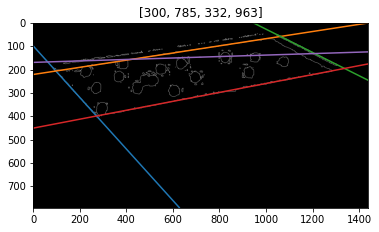

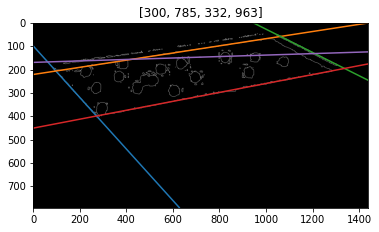

In [8]:
plt.imshow(edges,cmap = 'gray')

lines,consensus_list = ransac_line(edges,N=5000,max_error=2,existing_line_threshold=100)

(793.0, 0.0)

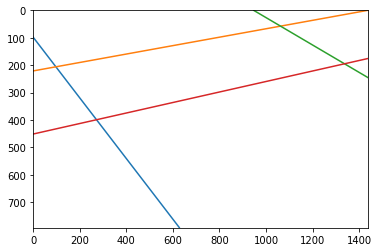

In [9]:
for l in lines:
    l = l.ravel()
    #ax + by + c = 0 y = -ax/b -c/b
    m = -l[0]/(l[1]+1e-19)
    c = -l[2]/(l[1]+1e-19)    
    plt.plot(m*np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int) + c,np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int))

plt.xlim(0,edges.shape[1])
plt.ylim(edges.shape[0],0)

Now lets find the corners, by getting the intercepts using the cross product

<ipython-input-10-0ade83737d8f>:7: RuntimeWarning: invalid value encountered in true_divide
  point = point/point[0,2]


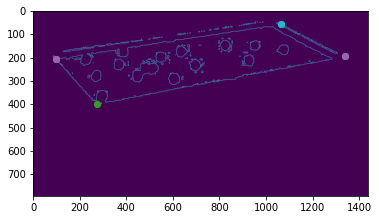

In [10]:
intercepts = []
plt.imshow(edges)
for l1 in lines:
    for l2 in lines:
        
        point = np.cross(l1,l2)
        point = point/point[0,2]
        plt.plot(point[0,1],point[0,0],'o')
        
        if (point[0,0]>0)&(point[0,1]>0)&(point[0,0]<edges.shape[0])&(point[0,1]<edges.shape[1]):
            intercepts.append(point)
        
plt.xlim(0,edges.shape[1])
plt.ylim(edges.shape[0],0)
plt.show()

intercepts = np.unique(np.vstack((intercepts)),axis=0)
intercepts = intercepts[np.argsort(intercepts[:,0]),:]

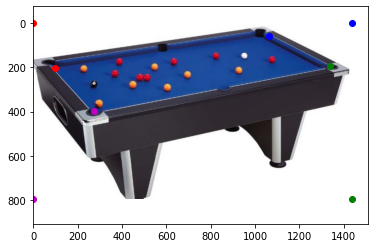

In [11]:
image_corners = np.array([[0,edges.shape[1]],
                          [edges.shape[0],edges.shape[1]],
                          [0,0],
                         [edges.shape[0],0]])

#Sanity check on correspondences
colour_list = ['b','g','r','m']
plt.imshow(im)
for i in range(4):
    plt.plot(intercepts[i,1],intercepts[i,0],'o',color=colour_list[i])
    plt.plot(image_corners[i,1],image_corners[i,0],'o',color=colour_list[i])
plt.axis('equal')
plt.show()

In [12]:
H,_ = cv2.findHomography(intercepts[:,[1,0]],image_corners[:,[1,0]],method=0)

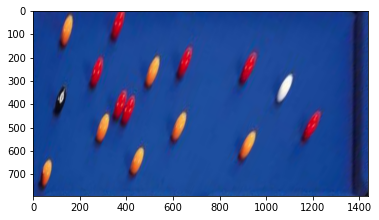

In [13]:
rectified_image = cv2.warpPerspective(im,H,(edges.shape[1],edges.shape[0]))

plt.imshow(rectified_image,cmap='gray')
plt.show()


### Activity

Modify the code above to find all the circles in the image using a ransac-like approach.


### Wrap up

Some take home messages. 

- Images and objects in these have geometric properties that impose a range of constraints.
- We can use these constraints to aid in various detection strategies
- This is quite useful in a range of applications, particularly when you have a lot of prior knowledge about the problem (eg. sport, many industrial production lines).
- BUT, these approaches are difficult to tune, and require MANY hand-tuned thresholds
- As a result, it's quite easy to make these work on one image, only to find them fail on another
- Data-driven approaches (like neural networks) and systematic testing strategies can avoid this.
- We can combine geometry and learning neural networks for improved performance (an active area of modern computer vision research)


